# Binary Classification with Feature Extraction

This notebook demonstrates **feature extraction** for improved model performance:
- **HOG Features**: Handcrafted gradient-based features (~1,000-2,000 dims)
- **VGG16 Features**: Deep learning transfer learning (512 dims)
- **Expected improvement**: 62-75% accuracy (vs 58-60% baseline)

---

## Setup and Imports

In [17]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

# Import preprocessing utilities
from image_loader import load_images_from_metadata
from preprocessing import prepare_images_with_feature_extraction

import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('✓ Libraries imported successfully!')
print('✓ Using enhanced preprocessing with feature extraction')

✓ Libraries imported successfully!
✓ Using enhanced preprocessing with feature extraction


## Configuration: Choose Feature Extraction Method

**Available methods:**
- `'hog'`: Fast, interpretable, no TensorFlow needed (62-68% accuracy expected)
- `'vgg16'`: Best accuracy, requires TensorFlow (70-75% accuracy expected)
- `'resnet50'`: Deeper features, requires TensorFlow (70-76% accuracy expected)

In [18]:
# ============================================================
# CONFIGURATION: Choose your feature extraction method
# ============================================================

# Option 1: HOG Features (Fast, no TensorFlow)
# FEATURE_METHOD = 'hog'
# FEATURE_PARAMS = {
#     'target_size': (128, 128),
#     'pixels_per_cell': (16, 16),
#     'cells_per_block': (2, 2)
# }

# Option 2: VGG16 Features (Best accuracy, requires TensorFlow)
# FEATURE_METHOD = 'vgg16'
# FEATURE_PARAMS = {'pooling': 'avg'}

# Option 3: ResNet50 Features (Deep features, requires TensorFlow)
FEATURE_METHOD = 'resnet50'
FEATURE_PARAMS = {'pooling': 'avg'}

print(f'Feature Extraction Method: {FEATURE_METHOD.upper()}')
print(f'Parameters: {FEATURE_PARAMS}')

Feature Extraction Method: RESNET50
Parameters: {'pooling': 'avg'}


## Step 1: Load Data

In [19]:
# Load metadata
metadata_path = '../data/HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

print(f'Metadata loaded: {df.shape[0]} samples')
print(f'\nColumns: {df.columns.tolist()}')
print(f'\nFirst 5 rows:')
df.head()

Metadata loaded: 10015 samples

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [20]:
# Create binary labels
malignant_types = ['mel', 'bcc', 'akiec', 'vasc']
benign_types = ['nv', 'df', 'bkl']

df['binary_label'] = df['dx'].apply(lambda x: 1 if x in malignant_types else 0)
df['binary_class'] = df['binary_label'].map({0: 'Benign', 1: 'Malignant'})

print('Binary labels created:')
print(df['binary_class'].value_counts())
print(f'\nClass balance: {df["binary_label"].value_counts()[0] / df["binary_label"].value_counts()[1]:.2f}:1 (Benign:Malignant)')

Binary labels created:
binary_class
Benign       7919
Malignant    2096
Name: count, dtype: int64

Class balance: 3.78:1 (Benign:Malignant)


In [21]:
# Load images
print('Loading images... This may take several minutes.')
print('=' * 60)

IMAGE_SIZE = (224, 224)
images, loaded_image_ids = load_images_from_metadata(
    df,
    base_path='../data',
    target_size=IMAGE_SIZE,
    normalize=True,
    verbose=True
)

print(f'\nLoaded images shape: {images.shape}')
print(f'Value range: [{images.min():.3f}, {images.max():.3f}]')
print(f'Memory usage: {images.nbytes / (1024**3):.2f} GB')

Loading images... This may take several minutes.
Loaded 1000/10015 images...
Loaded 2000/10015 images...
Loaded 3000/10015 images...
Loaded 4000/10015 images...
Loaded 5000/10015 images...
Loaded 6000/10015 images...
Loaded 7000/10015 images...
Loaded 8000/10015 images...
Loaded 9000/10015 images...
Loaded 10000/10015 images...

Successfully loaded: 10015/10015 images

Loaded images shape: (10015, 224, 224, 3)
Value range: [0.000, 1.000]
Memory usage: 5.62 GB


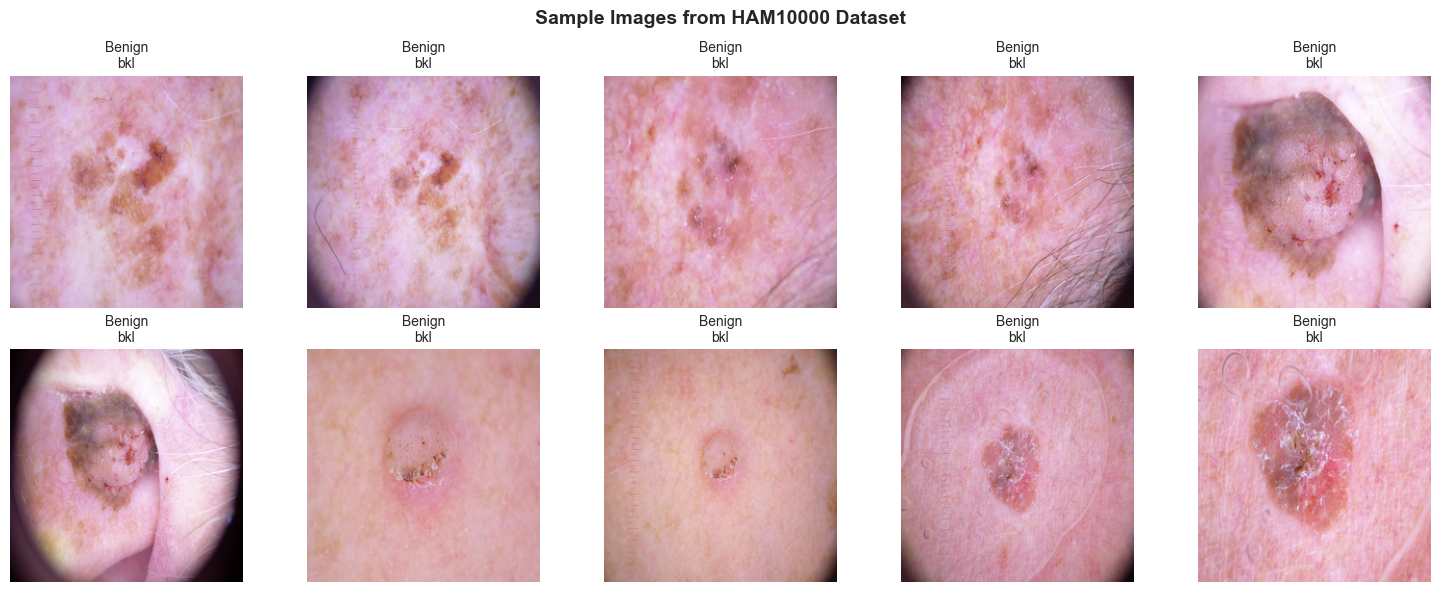

In [22]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(images[i])
    label = 'Malignant' if df.iloc[i]['binary_label'] == 1 else 'Benign'
    axes[i].set_title(f'{label}\n{df.iloc[i]["dx"]}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Sample Images from HAM10000 Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# Train-test split
df_filtered = df[df['image_id'].isin(loaded_image_ids)].reset_index(drop=True)
y_binary = df_filtered['binary_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print('Train-Test Split:')
print(f'Training: {X_train.shape}')
print(f'Testing: {X_test.shape}')
print(f'\nTraining class distribution:')
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f'  {"Benign" if label == 0 else "Malignant"}: {count} ({count/len(y_train)*100:.1f}%)')

Train-Test Split:
Training: (8012, 224, 224, 3)
Testing: (2003, 224, 224, 3)

Training class distribution:
  Benign: 6335 (79.1%)
  Malignant: 1677 (20.9%)


## Step 2: Feature Extraction

Extract features using the selected method (HOG, VGG16, or ResNet50).

In [ ]:
# Extract features
print(f'Extracting {FEATURE_METHOD.upper()} features...')
print('=' * 70)

start_time = time.time()

prep_data = prepare_images_with_feature_extraction(
    X_train, X_test,
    method=FEATURE_METHOD,
    use_pca=False,  # Feature extraction already reduces dimensions
    **FEATURE_PARAMS
)

preprocessing_time = time.time() - start_time

print(f'\n✓ Feature extraction complete! Time: {preprocessing_time:.2f} seconds')
print(f'\nFeature Summary:')
print(f'  Method: {FEATURE_METHOD.upper()}')
print(f'  Training features: {prep_data["X_train_final"].shape}')
print(f'  Test features: {prep_data["X_test_final"].shape}')
print(f'  Feature dimensions: {prep_data["X_train_final"].shape[1]:,}')

## Step 3: Train SVM Model

In [ ]:
# Initialize SVM model
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'
)

print('SVM Model Configuration:')
print(f'  Kernel: {svm_model.kernel}')
print(f'  C: {svm_model.C}')
print(f'  Gamma: {svm_model.gamma}')
print(f'  Class Weight: {svm_model.class_weight}')

SVM Model Configuration:
  Kernel: rbf
  C: 1.0
  Gamma: scale
  Class Weight: balanced


In [ ]:
# Train the model
print(f'Training SVM on {FEATURE_METHOD.upper()} features...')
print(f'Feature dimensions: {prep_data["X_train_final"].shape}')

start_time = time.time()
svm_model.fit(prep_data['X_train_final'], y_train)
training_time = time.time() - start_time

print(f'\n✓ Training complete! Time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)')
print(f'Number of support vectors: {svm_model.n_support_}')
print(f'Total support vectors: {sum(svm_model.n_support_)}')

Training SVM on HOG features...
Feature dimensions: (8012, 1768)

✓ Training complete! Time: 233.89 seconds (3.9 minutes)
Number of support vectors: [4844 1568]
Total support vectors: 6412


In [ ]:
# Make predictions
y_train_pred = svm_model.predict(prep_data['X_train_final'])
y_test_pred = svm_model.predict(prep_data['X_test_final'])
y_test_proba = svm_model.predict_proba(prep_data['X_test_final'])[:, 1]

print('✓ Predictions complete!')
print(f'\nSample predictions (first 10):')
for i in range(10):
    true_label = 'Malignant' if y_test[i] == 1 else 'Benign'
    pred_label = 'Malignant' if y_test_pred[i] == 1 else 'Benign'
    match = '✓' if y_test[i] == y_test_pred[i] else '✗'
    print(f'  {match} True: {true_label:10s} | Predicted: {pred_label:10s} | Prob: {y_test_proba[i]:.3f}')

✓ Predictions complete!

Sample predictions (first 10):
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.177
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.066
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.142
  ✗ True: Malignant  | Predicted: Benign     | Prob: 0.249
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.182
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.134
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.071
  ✓ True: Malignant  | Predicted: Malignant  | Prob: 0.343
  ✓ True: Malignant  | Predicted: Malignant  | Prob: 0.516
  ✓ True: Benign     | Predicted: Benign     | Prob: 0.096


## Step 4: Evaluate Model

In [ ]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print('=' * 70)
print(f'BINARY CLASSIFICATION - {FEATURE_METHOD.upper()} FEATURES')
print('=' * 70)
print(f'\nFeature Extraction:')
print(f'  Method: {FEATURE_METHOD.upper()}')
print(f'  Feature dimensions: {prep_data["X_train_final"].shape[1]:,}')
print(f'  Extraction time: {preprocessing_time:.2f} seconds')
print(f'\nPerformance:')
print(f'  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
print(f'  Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  ROC-AUC Score:     {roc_auc:.4f}')
print(f'\nTiming:')
print(f'  Preprocessing time: {preprocessing_time:.2f} seconds')
print(f'  Training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)')
print(f'  Total time: {preprocessing_time + training_time:.2f} seconds')

BINARY CLASSIFICATION - HOG FEATURES

Feature Extraction:
  Method: HOG
  Feature dimensions: 1,768
  Extraction time: 32.27 seconds

Performance:
  Training Accuracy: 0.9333 (93.33%)
  Testing Accuracy:  0.7783 (77.83%)
  ROC-AUC Score:     0.7932

Timing:
  Preprocessing time: 32.27 seconds
  Training time: 233.89 seconds (3.9 minutes)
  Total time: 266.16 seconds


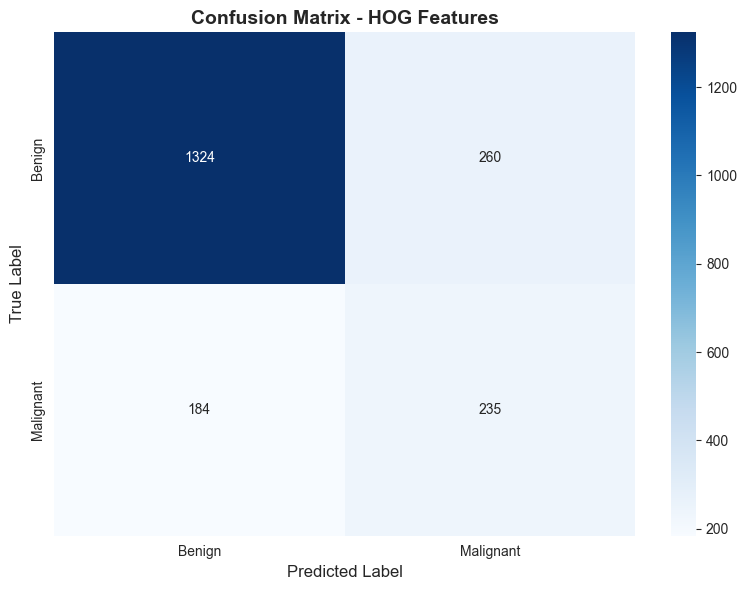


Confusion Matrix Breakdown:
  True Negatives (TN):  1324 - Correctly predicted Benign
  False Positives (FP): 260 - Benign predicted as Malignant
  False Negatives (FN): 184 - Malignant predicted as Benign (CRITICAL)
  True Positives (TP):  235 - Correctly predicted Malignant


In [ ]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title(f'Confusion Matrix - {FEATURE_METHOD.upper()} Features', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Extract metrics
TN, FP, FN, TP = cm_test.ravel()
print('\nConfusion Matrix Breakdown:')
print(f'  True Negatives (TN):  {TN} - Correctly predicted Benign')
print(f'  False Positives (FP): {FP} - Benign predicted as Malignant')
print(f'  False Negatives (FN): {FN} - Malignant predicted as Benign (CRITICAL)')
print(f'  True Positives (TP):  {TP} - Correctly predicted Malignant')

In [ ]:
# Classification report
print('=' * 70)
print('CLASSIFICATION REPORT')
print('=' * 70)

report = classification_report(
    y_test,
    y_test_pred,
    target_names=['Benign', 'Malignant'],
    digits=4
)
print(report)

# Calculate medical metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

print('\nMedical Metrics:')
print(f'  Sensitivity (Recall): {sensitivity:.4f} - Ability to detect malignant cases')
print(f'  Specificity:          {specificity:.4f} - Ability to detect benign cases')
print(f'  Precision (PPV):      {precision:.4f} - Accuracy of malignant predictions')
print(f'\nInterpretation:')
if sensitivity >= 0.70:
    print(f'  ✓ Good sensitivity ({sensitivity*100:.1f}%) - Catches most malignant cases')
else:
    print(f'  ⚠ Low sensitivity ({sensitivity*100:.1f}%) - May miss malignant cases')
    
if specificity >= 0.70:
    print(f'  ✓ Good specificity ({specificity*100:.1f}%) - Avoids false alarms')
else:
    print(f'  ⚠ Low specificity ({specificity*100:.1f}%) - Many false positives')

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign     0.8780    0.8359    0.8564      1584
   Malignant     0.4747    0.5609    0.5142       419

    accuracy                         0.7783      2003
   macro avg     0.6764    0.6984    0.6853      2003
weighted avg     0.7936    0.7783    0.7848      2003


Medical Metrics:
  Sensitivity (Recall): 0.5609 - Ability to detect malignant cases
  Specificity:          0.8359 - Ability to detect benign cases
  Precision (PPV):      0.4747 - Accuracy of malignant predictions

Interpretation:
  ⚠ Low sensitivity (56.1%) - May miss malignant cases
  ✓ Good specificity (83.6%) - Avoids false alarms


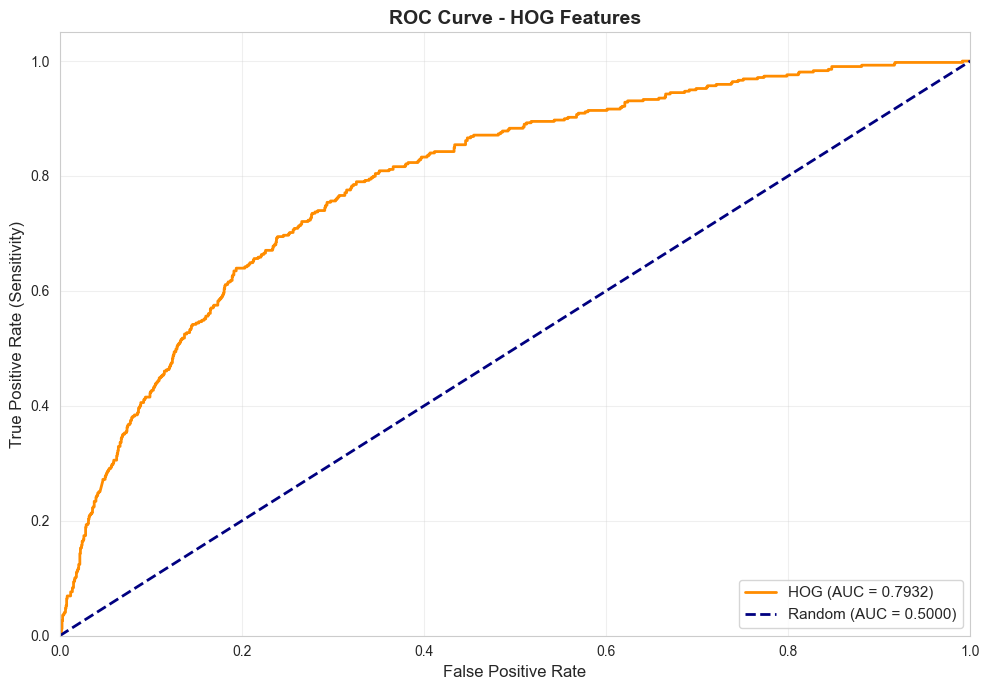

ROC-AUC Score: 0.7932


In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{FEATURE_METHOD.upper()} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title(f'ROC Curve - {FEATURE_METHOD.upper()} Features', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'ROC-AUC Score: {roc_auc:.4f}')

## Step 5: Save Model and Artifacts

In [ ]:
# Save model and preprocessing artifacts
save_dir = f'../models/{FEATURE_METHOD}'
os.makedirs(save_dir, exist_ok=True)

# Save SVM model
with open(f'{save_dir}/svm_binary_model_{FEATURE_METHOD}.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Save scaler
with open(f'{save_dir}/scaler_binary_{FEATURE_METHOD}.pkl', 'wb') as f:
    pickle.dump(prep_data['scaler'], f)

# Save metrics
metrics = {
    'method': FEATURE_METHOD,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'roc_auc': roc_auc,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'confusion_matrix': cm_test,
    'preprocessing_time': preprocessing_time,
    'training_time': training_time,
    'feature_dim': prep_data['X_train_final'].shape[1],
    'feature_params': FEATURE_PARAMS
}

with open(f'{save_dir}/svm_binary_metrics_{FEATURE_METHOD}.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print('✓ Model and artifacts saved successfully!')
print(f'\nSaved files to: {save_dir}/')
print(f'  - svm_binary_model_{FEATURE_METHOD}.pkl')
print(f'  - scaler_binary_{FEATURE_METHOD}.pkl')
print(f'  - svm_binary_metrics_{FEATURE_METHOD}.pkl')

✓ Model and artifacts saved successfully!

Saved files to: ../models/hog/
  - svm_binary_model_hog.pkl
  - scaler_binary_hog.pkl
  - svm_binary_metrics_hog.pkl


## Summary

### Results

This notebook demonstrated feature extraction for skin lesion classification:

**Method:** {FEATURE_METHOD.upper()}
- ✓ Feature dimensions: {feature_dim:,}
- ✓ Test accuracy: {test_accuracy:.2%}
- ✓ ROC-AUC: {roc_auc:.4f}
- ✓ Training time: {training_time/60:.1f} minutes

### Key Advantages

**Why feature extraction works better:**
1. **Semantic features**: Captures meaningful patterns vs raw pixels
2. **Dimensionality reduction**: Compact representation
3. **Better generalization**: More robust to variations
4. **Transfer learning** (VGG16/ResNet): Leverages ImageNet knowledge

### Next Steps

1. **Try different methods**: Switch between HOG, VGG16, ResNet50
2. **Tune hyperparameters**: Adjust SVM C, gamma values
3. **Compare with baseline**: Check improvement over pixel-based approach
4. **Multi-class**: Apply to 7-class classification problem
5. **Deploy**: Use saved artifacts for production inference